# Week 6: Spatial networks

In this code sample, we will test some road networks for planarity and we will construct a network Voronoi diagram. We will be using `networkx` for representing and manipulating networks, `osmnx` to download street networks from OpenStreetMap, and Python's standard `random` package to choose random seed locations in our diagram.

In [ ]:
!pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import networkx
import osmnx
import random

## Access and Construct Graphs
As in a previous lesson, we will start by accessing the street network of Soho, an area of central London to the west of King's.

In [ ]:
# Choose a place whose crimes we will analyse with respect to its street network
PLACE_OF_INTEREST = "Soho, London, United Kingdom"
# Get the network of streets in Soho
soho_graph = osmnx.graph_from_place(PLACE_OF_INTEREST)

We can see what this street network looks like using a simple osmnx method.

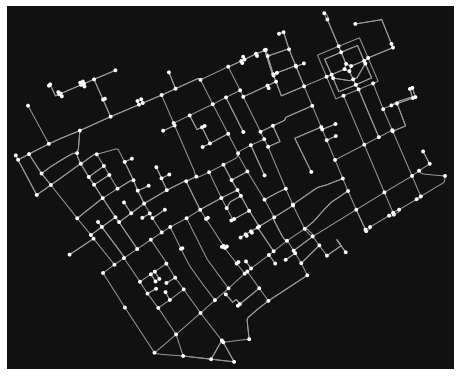

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
osmnx.plot_graph(soho_graph)

We can also plot the spatial graph as an interative [Leaflet](https://leafletjs.com/) web map via [folium](https://python-visualization.github.io/folium/).

In [ ]:
osmnx.plot_graph_folium(soho_graph)

## [Planarity](https://networkx.org/documentation/stable/reference/algorithms/planarity.html) and Kuratowski's Theorem
We can ask `networkx` whether this is a planar graph, and it will apply Kuratowski's Theorem.

In [ ]:
networkx.check_planarity(soho_graph)

(True, <networkx.algorithms.planarity.PlanarEmbedding at 0x7f5ab33a26d0>)

You should see that this returns True: the street network of Soho is a planar graph.

Let's try an area directly around King's, so a little to the east of Soho around Waterloo Bridge. Instead of downloading the area by name, like above, we can use the coordinates (longitude and latitude) of a bounding box and retrieve all streets within that area.

In [ ]:
# The area around King's including an underpass - note that tightening the 
# bounding box will exclude the underpass and it will be planar
kings_graph = osmnx.graph_from_bbox(
    north=51.5147, south=51.5053, west=-0.1207, east=-0.1103)
is_planar, counterexample = networkx.check_planarity(
    kings_graph, counterexample=True)

is_planar

False

In [ ]:
osmnx.plot_graph_folium(kings_graph)

In this case, you should see it returns False, because it is not planar. This is because there is a road tunnel that travels from Waterloo Bridge to the south of King's up to a road to the north of King's. The tunnel crosses under roads and we cannot disentangle the roads to form a planar graph. If you try tightening the coordinates of the bounding box above, you will exclude the start or end of the tunnel so the tunnel will be excluded and the graph returned will be planar.

We can also ask networkx to return a part of the network that prevents it from being planar, and draw this. It will produce a simple part of the network that is non-planar.

In [ ]:
counterexample

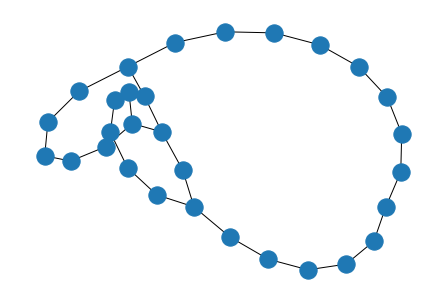

In [ ]:
networkx.draw(counterexample)

## Voronoi Diagram
Next, let's create a node network Voronoi diagram using the street network of Soho from above. As this is not provided by the libraries, we need to construct it step-by-step ourselves. We first choose a few of the network nodes (road intersections) to be our seed nodes. We will choose these at random.

In [ ]:
NUMBER_OF_SEEDS = 10

all_nodes = list(soho_graph.nodes)
seeds = random.choices(all_nodes, k=NUMBER_OF_SEEDS)

seeds

[26699545,
 25502552,
 6313625295,
 771982865,
 4731047323,
 700757166,
 4731047333,
 9791153,
 21665930,
 25501065]

The ``networkx`` function `single_source_dijkstra_path_length` takes a single node and returns the length of the shortest path from this node to every other reachable node. It is important to note that not every node in the network will be reachable from each seed because the street network is directed, some streets are one-way. Below we create a dictionary from each seed node to the shortest distances to each other reachable node. The attribute 'length' on each edge gives the length of that street (downloaded by ``osmnx``).

In [ ]:
distances = {seed: networkx.single_source_dijkstra_path_length(
    soho_graph, seed, weight='length') for seed in seeds}

Next, we will define some functions to help us construct the diagram. The first function below takes a list of tuples of the form (**node**, **distance**) giving the distance to a given node. The function will return the nearest node, meaning the one with the lowest distance value. It does this by sorting the list by the **distance** and then taking the first in the list. If the list is empty, it will return None as there is no node to return.

In [ ]:
def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] \
        if len(node_distances) > 0 else None

We then use the above function in another function, which gets the nearest seed node for a given network node. It first constructs a list of (seed, distance) tuples with the distance from each seed to the given network node, and then uses nearest_from_list to get the nearest of these seeds.

In [ ]:
def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) \
        for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)

Our next function is to get the nearest seed for an edge, as it is the edges that we will colour as cells in the Voronoi diagram. This does the following: (1) gets the nearest seed to the node at each end of the edge, (2) if for either node there is no closest seed because there is no path to any seed the nearest seed will be None so we remove these, (3) return the one seed from the pair that is nearest (shortest distance).

In [ ]:
def nearest_for_edge(edge):
    nearest_to_ends_all = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)

Now that we can determine the nearest seed node for each edge, and so construct the Voronoi cells, we need to work out how to display the diagram. First, we will assign a different colour to each seed. osmnx provides a method to get produce a range of distinct colours for creating a map. We will also create a function colour_for_seed_distance that takes a (seed, distance) tuple and returns the colour for that seed node: this is helpful for our next step.

In [ ]:
colours = osmnx.plot.get_colors(NUMBER_OF_SEEDS)

def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]

Using all the above, we can create the Voronoi diagram. We get the nearest seed for each edge and then the colour for the edge given its nearest seed. If there is no nearest seed for an edge because no seed can be reached from that street along the directed edges, it will be coloured black (symbol 'k'), meaning that the road will be invisible when plotted on a black background and so will not be part of the diagram.

In [ ]:
edge_nearest_seeds = [nearest_for_edge(edge) for edge in soho_graph.edges]
# Note that edges not connected to a seed shown in black, so invisible on black background
edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
# For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
node_colours = ['r' if node in seeds else 'w' for node in all_nodes]

We can now draw the diagram. We provide the network, the edge colours, and the node colours, and specify the background to be black.

263

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


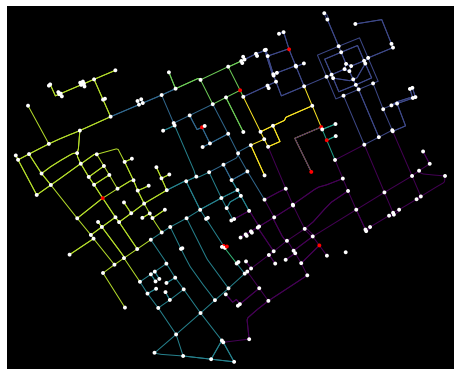

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
osmnx.plot.plot_graph(soho_graph, edge_color = edge_colours, node_color = node_colours, bgcolor = 'k', save = True, filepath = 'nvd.png')